
## Importing required libraries and Dataset

In [2]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import isbnlib
from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
import copy
from scipy import stats
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import goodreads_api_client as gr
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

## Loading the Dataset

In [3]:
df = pd.read_csv("C:\\Users\\nidhi\\OneDrive\\Desktop\\books.csv", error_bad_lines = False)


C:\Users\nidhi\AppData\Local\Temp\ipykernel_22100\3440572659.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("C:\\Users\\nidhi\\OneDrive\\Desktop\\books.csv", error_bad_lines = False)
b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [4]:
df.index = df['bookID']

In [5]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11123 entries, 1 to 45641
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.1+ MB


## Shape of the Dataset

In [7]:
df.shape


(11123, 12)

## Checking Null values

In [8]:
#apparently no Nulls!
df["average_rating"].isnull().value_counts()

False    11123
Name: average_rating, dtype: int64

In [9]:
#drop NaNs anyway
df.dropna(0, inplace=True)

C:\Users\nidhi\AppData\Local\Temp\ipykernel_22100\1501041666.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df.dropna(0, inplace=True)


In [10]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [11]:
df = df[df['  num_pages'] >= 30]
df.shape

(10818, 12)

In [12]:
z = np.abs(stats.zscore(df['  num_pages']))
for i in range(len(list(np.where(z>=3)[0]))):
    df.drop(df.index[np.where(z>=3)[0][i]], inplace=True)
df.shape

(10648, 12)

 ## Data Processing 
 Here we are going to fit the model using the PCA. Now let's check out what is PCA!Principal Component Analysis : PCA is a most widely used tool in exploratory data analysis and in machine learning for predictive models. Moreover, PCA is an unsupervised statistical technique used to examine the interrelations among a set of variables. It is also known as a general factor analysis where regression determines a line of best fit.Let's scale our numerical data for PCA:

In [13]:
ss = StandardScaler()
df2 = ss.fit_transform(df[['average_rating', 'ratings_count', 'text_reviews_count']])
df2

array([[ 1.82702667, 18.40507397, 10.32981553],
       [ 1.59769767, 18.91427722, 10.95255808],
       [ 1.39703479, -0.10506684, -0.1181234 ],
       ...,
       [ 0.07839302, -0.1539079 , -0.17504895],
       [-0.60959399, -0.15435972, -0.15823872],
       [-0.0649376 , -0.16017139, -0.20675915]])

In [14]:
pca = PCA()
pca_data = pca.fit_transform(df2)
new_df = pd.DataFrame(pca_data)
new_df

,0,1,2
0,20.391720,-0.628885,-5.707199
1,21.177067,-0.352177,-5.627508
2,-0.074463,-1.403965,-0.005951
3,24.270439,-0.367156,-4.875910
4,-0.295393,0.535559,-0.036600
...,...,...,...
10643,-0.234863,-0.379764,-0.030178
10644,-0.217825,-0.436170,-0.024247
10645,-0.227533,-0.092121,-0.014749
10646,-0.256899,0.595363,-0.004154


Text(0.5, 1.0, 'Elbow Curve')

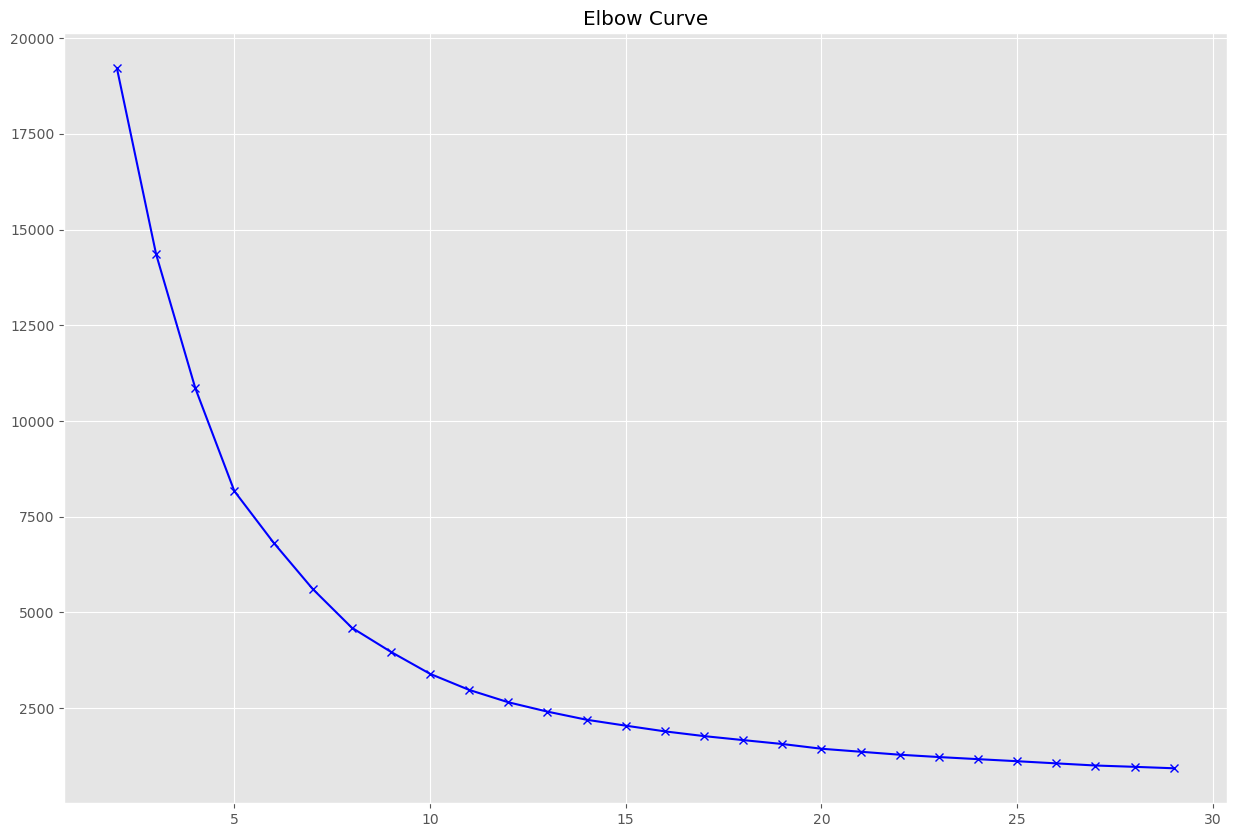

In [15]:
#in the range of 2-30, lets find the best n_clusters that best explain our books.# 
X = new_df
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

In [16]:
CENTROIDS = 7 

## Now let's approach with K-Means Clustering! Will that be beneficial? Let's find out!

In [17]:
k_means = KMeans(n_clusters = CENTROIDS)
new_df['idx'] = k_means.fit_predict(new_df)
new_df

,0,1,2,idx
0,20.391720,-0.628885,-5.707199,1
1,21.177067,-0.352177,-5.627508,1
2,-0.074463,-1.403965,-0.005951,2
3,24.270439,-0.367156,-4.875910,1
4,-0.295393,0.535559,-0.036600,5
...,...,...,...,...
10643,-0.234863,-0.379764,-0.030178,5
10644,-0.217825,-0.436170,-0.024247,5
10645,-0.227533,-0.092121,-0.014749,5
10646,-0.256899,0.595363,-0.004154,0


using 7 as our k, we predict what category each book falls into. As you can see the first two rows are the same category, which makes sense because they are both harry potter books



## Data Visualization 
Data visualization is the graphical representation of information and data. By using visual elements like charts, graphs, and maps, data visualization tools provide an accessible way to see and understand trends, outliers, and patterns in data.

Text(0.5, 0.92, 'plotting the 3 principle components')

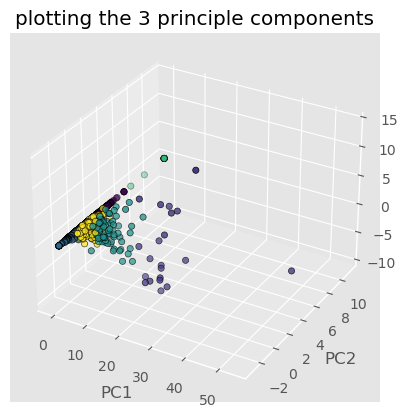

In [18]:
ax3 = plt.axes(projection='3d')
ax3.scatter(new_df[0], new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plotting the 3 principle components')

Text(0.5, 1.0, 'plotting 2 principle components')

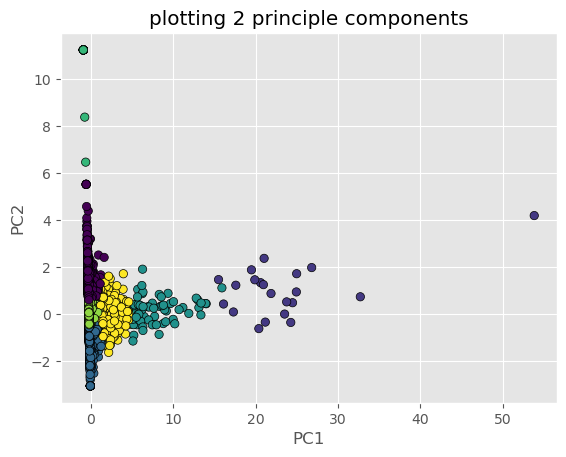

In [19]:
plt.scatter(new_df[0], new_df[1], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plotting 2 principle components')

Text(0.5, 1.0, 'plotting 2 principle components')

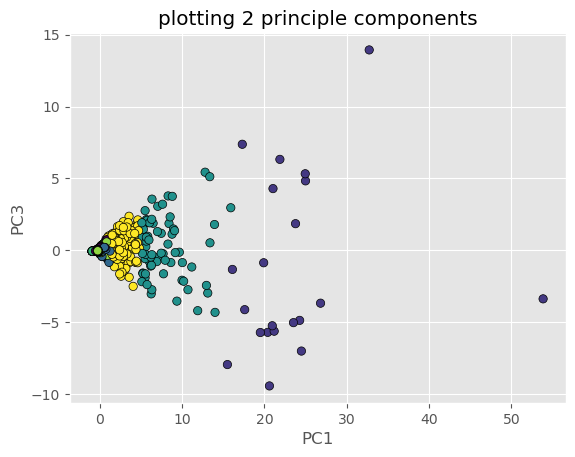

In [20]:
plt.scatter(new_df[0], new_df[2], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('plotting 2 principle components')

Text(0.5, 1.0, 'plotting 2 principle components')

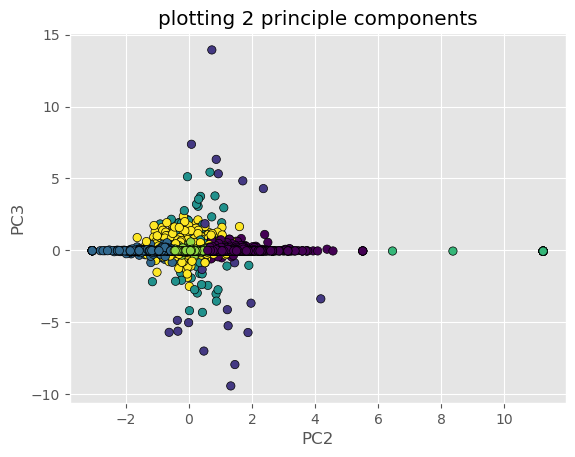

In [21]:
plt.scatter(new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('plotting 2 principle components')

## outliers
Many machine learning algorithms are sensitive to the range and distribution of attribute values in the input data. Outliers in input data can skew and mislead the training process of machine learning algorithms resulting in longer training times, less accurate models and ultimately poorer results.

In [22]:
z = np.abs(stats.zscore(new_df[[0,1,2]]))
to_drop = np.unique(np.where(z>=3)[0])
print(to_drop, type(to_drop))

[    0     1     3   224   228   252   270   280   282   285   292   294
   315   335   342   355   390   401   484   491   502   543   550   562
   568   595   600   631   643   645   652   727   746   752   811   854
   866   919   942   963   980  1018  1076  1103  1114  1128  1143  1183
  1213  1241  1340  1351  1352  1358  1362  1367  1388  1393  1398  1406
  1436  1455  1484  1485  1487  1505  1530  1574  1592  1601  1617  1701
  1705  1711  1717  1775  1785  1848  1852  1879  1897  1906  1921  1965
  2017  2018  2031  2060  2082  2097  2160  2316  2327  2332  2415  2416
  2433  2468  2522  2539  2628  2634  2710  2725  2808  2811  2816  2916
  2978  3010  3087  3216  3336  3338  3397  3400  3473  3476  3477  3569
  3742  3901  3950  3974  3981  3990  4074  4226  4241  4263  4329  4447
  4451  4471  4473  4477  4543  4545  4550  4579  4585  4591  4716  4791
  4798  4857  4868  4935  4973  5037  5039  5089  5171  5291  5322  5397
  5398  5418  5522  5540  5867  5926  6055  6095  6

In [23]:
new_df.drop(to_drop, inplace=True)
new_df

,0,1,2,idx
2,-0.074463,-1.403965,-0.005951,2
4,-0.295393,0.535559,-0.036600,5
5,0.267480,-2.273782,0.011227,2
6,2.474187,-1.138414,-0.493767,6
7,-0.059085,-0.828554,0.059845,2
...,...,...,...,...
10643,-0.234863,-0.379764,-0.030178,5
10644,-0.217825,-0.436170,-0.024247,5
10645,-0.227533,-0.092121,-0.014749,5
10646,-0.256899,0.595363,-0.004154,0


C:\Users\nidhi\AppData\Local\Temp\ipykernel_22100\2857279436.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax3 = Axes3D(fig3)


Text(0.5, 0.92, 'plotting principle components')

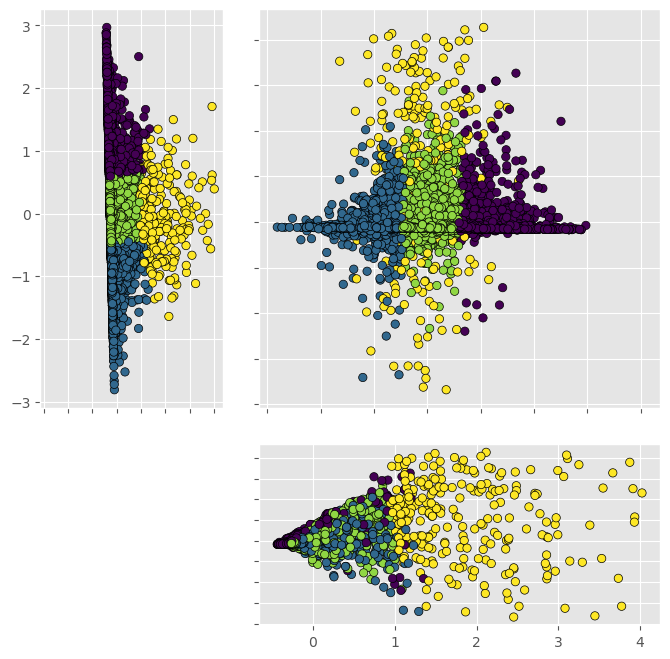

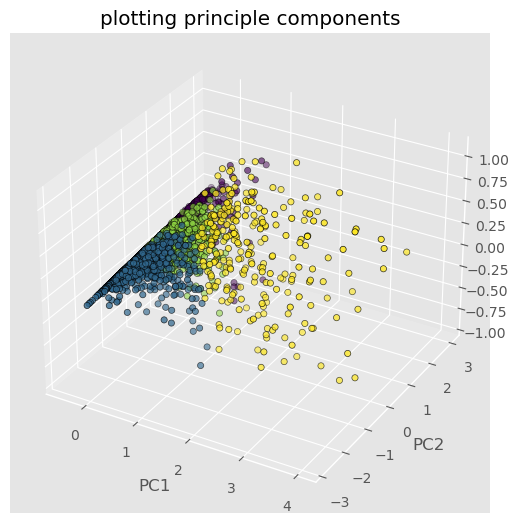

In [24]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)
fig3 = plt.figure()
ax3 = Axes3D(fig3)

pc1_2 = fig.add_subplot(grid[:-1, 1:])
pc0_1 = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharex=pc1_2)
pc0_2 = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharey=pc1_2)

# scatter points on the main axes
ax3.scatter(new_df[0], new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])

# PCs on the attached axes
pc0_1.scatter(new_df[0], new_df[1], edgecolor='black', c=new_df['idx'])
pc0_2.scatter(new_df[0], new_df[2], edgecolor='black', c=new_df['idx'])
pc1_2.scatter(new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plotting principle components')

## Machine Learning Models


In [25]:
#i was trying to put them back together but was getting some nasty NaNs.. 
#i had forgotten that i had dropped many columns
df.shape, new_df.shape
#see this is a problem, time to M E R G E

((10648, 12), (10405, 4))

In [26]:
df3 = df.copy()
#dropping all the outliers we found in the 2nd z score test for PCs (this took like way too long to figure out)
df3.drop(df3.index[to_drop], inplace=True)
df3.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
9,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books


In [27]:
df3.shape, new_df.shape


((10405, 12), (10405, 4))

In [28]:
#no NaNs
df3.isnull().values.any(), new_df.isnull().values.any()

(False, False)

In [29]:
for col in df3:
    print(col, df3.isnull()[col].value_counts(), "\n")

bookID False    10405
Name: bookID, dtype: int64 

title False    10405
Name: title, dtype: int64 

authors False    10405
Name: authors, dtype: int64 

average_rating False    10405
Name: average_rating, dtype: int64 

isbn False    10405
Name: isbn, dtype: int64 

isbn13 False    10405
Name: isbn13, dtype: int64 

language_code False    10405
Name: language_code, dtype: int64 

  num_pages False    10405
Name:   num_pages, dtype: int64 

ratings_count False    10405
Name: ratings_count, dtype: int64 

text_reviews_count False    10405
Name: text_reviews_count, dtype: int64 

publication_date False    10405
Name: publication_date, dtype: int64 

publisher False    10405
Name: publisher, dtype: int64 



In [30]:
#reseting index since we had dropped outliers before
new_df = new_df.reset_index()
new_df = new_df.drop("index", axis=1)
new_df

,0,1,2,idx
0,-0.074463,-1.403965,-0.005951,2
1,-0.295393,0.535559,-0.036600,5
2,0.267480,-2.273782,0.011227,2
3,2.474187,-1.138414,-0.493767,6
4,-0.059085,-0.828554,0.059845,2
...,...,...,...,...
10400,-0.234863,-0.379764,-0.030178,5
10401,-0.217825,-0.436170,-0.024247,5
10402,-0.227533,-0.092121,-0.014749,5
10403,-0.256899,0.595363,-0.004154,0


In [31]:
#finally merging the two (PCA'd values with the original df)
df4 = df3.merge(new_df, right_index=True, left_index=True)
df4

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,0,1,2,idx
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,-0.059085,-0.828554,0.059845,2
9,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,1.358246,-0.311963,0.658274,6
10,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,0.635635,0.132229,0.253101,5
13,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,1.127437,0.133040,0.351088,6
14,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,0.477000,0.036854,0.349268,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10370,10370,Where the Red Fern Grows with Connections,Wilson Rawls/Rafe Martin/Borden Deal/Kemp P. B...,4.37,0030547741,9780030547744,eng,288,121,5,9/1/1998,Holt McDougal,-0.250062,-0.208377,-0.034245,5
10372,10372,Summer of the Monkeys,Wilson Rawls,4.03,0440415802,9780440415800,eng,288,11150,794,12/29/1998,Yearling,-0.319289,0.936172,-0.037508,0
10382,10382,Dreams from My Father: A Story of Race and Inh...,Barack Obama,3.88,0307383415,9780307383419,en-US,442,1225,181,1/9/2007,Crown,-0.232082,-0.523192,-0.033815,2
10403,10403,Doctor Who: Cat's Cradle-Time's Crucible,Marc Platt,3.22,0426203658,9780426203650,eng,275,589,40,2/20/1992,Virgin Publishing,-0.256899,0.595363,-0.004154,0


In [32]:
#reverifying there are no NaNs
for col in df4:
    print(col, df4.isnull()[col].value_counts(), "\n")

bookID False    2564
Name: bookID, dtype: int64 

title False    2564
Name: title, dtype: int64 

authors False    2564
Name: authors, dtype: int64 

average_rating False    2564
Name: average_rating, dtype: int64 

isbn False    2564
Name: isbn, dtype: int64 

isbn13 False    2564
Name: isbn13, dtype: int64 

language_code False    2564
Name: language_code, dtype: int64 

  num_pages False    2564
Name:   num_pages, dtype: int64 

ratings_count False    2564
Name: ratings_count, dtype: int64 

text_reviews_count False    2564
Name: text_reviews_count, dtype: int64 

publication_date False    2564
Name: publication_date, dtype: int64 

publisher False    2564
Name: publisher, dtype: int64 

0 False    2564
Name: 0, dtype: int64 

1 False    2564
Name: 1, dtype: int64 

2 False    2564
Name: 2, dtype: int64 

idx False    2564
Name: idx, dtype: int64 



## Creating the dummy dataframes

In [33]:
#adding a new col 'rating_between' for future dummy
for i in range(5):
    df4.loc[ (df4['average_rating'] >= i) & (df4['average_rating'] <= i+1), 'rating_between'] = f"between {i} and {i+1}"

In [34]:
#making a dummy col for each rating level
dummy_rating_df = df4['rating_between'].str.get_dummies(sep=",")
dummy_rating_df.head(3)

,between 2 and 3,between 3 and 4,between 4 and 5
4,0,0,1
9,0,1,0
10,0,0,1


In [35]:
#making a dummy col for each language
dummy_language_df = df4['language_code'].str.get_dummies(sep=",")
dummy_language_df.head(3)

,ara,en-CA,en-GB,en-US,eng,enm,fre,ger,grc,jpn,lat,mul,nl,por,spa,zho
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Here we are going to take weighted ratings instead of actual ratings

In [36]:
def weighted_rating(df):
    v = df['ratings_count']
    R = df['average_rating']
    C = df['average_rating'].mean()
    m = df['ratings_count'].quantile(0.9)
    return (v/(v+m) * R) + (m/(m+v) * C)

In [37]:
#readjusting the weight of "average rating" to be proportional to the quantile of ratings count
df4['weighted_score'] = weighted_rating(df4)

In [38]:
#renaming columns
df4.columns = ['bookID','title','authors','average_rating','isbn','isbn13','language_code',
               '  num_pages','ratings_count','text_reviews_count','publication_date',
               'publisher',"PC1","PC2","PC3",'idx','rating_between','weighted_score']
df4

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,PC1,PC2,PC3,idx,rating_between,weighted_score
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,-0.059085,-0.828554,0.059845,2,between 4 and 5,4.024275
9,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,1.358246,-0.311963,0.658274,6,between 3 and 4,3.947711
10,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,0.635635,0.132229,0.253101,5,between 4 and 5,4.309809
13,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,1.127437,0.133040,0.351088,6,between 4 and 5,4.329819
14,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,0.477000,0.036854,0.349268,5,between 4 and 5,3.983410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10370,10370,Where the Red Fern Grows with Connections,Wilson Rawls/Rafe Martin/Borden Deal/Kemp P. B...,4.37,0030547741,9780030547744,eng,288,121,5,9/1/1998,Holt McDougal,-0.250062,-0.208377,-0.034245,5,between 4 and 5,3.949384
10372,10372,Summer of the Monkeys,Wilson Rawls,4.03,0440415802,9780440415800,eng,288,11150,794,12/29/1998,Yearling,-0.319289,0.936172,-0.037508,0,between 4 and 5,3.968685
10382,10382,Dreams from My Father: A Story of Race and Inh...,Barack Obama,3.88,0307383415,9780307383419,en-US,442,1225,181,1/9/2007,Crown,-0.232082,-0.523192,-0.033815,2,between 3 and 4,3.945388
10403,10403,Doctor Who: Cat's Cradle-Time's Crucible,Marc Platt,3.22,0426203658,9780426203650,eng,275,589,40,2/20/1992,Virgin Publishing,-0.256899,0.595363,-0.004154,0,between 3 and 4,3.934986


## Making a Baseline model for the dataframe

In [39]:
model_df = pd.concat([dummy_rating_df, dummy_language_df, df4['weighted_score'], df4['average_rating'], df3['ratings_count'], df4['PC1'], df4['PC2'], df4['PC3']], axis=1)
model_df

,between 2 and 3,between 3 and 4,between 4 and 5,ara,en-CA,en-GB,en-US,eng,enm,fre,...,nl,por,spa,zho,weighted_score,average_rating,ratings_count,PC1,PC2,PC3
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.024275,4.42,6333,-0.059085,-0.828554,0.059845
9,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.947711,3.74,19,1.358246,-0.311963,0.658274
10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.309809,4.73,28242,0.635635,0.132229,0.253101
13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.329819,4.38,249558,1.127437,0.133040,0.351088
14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.983410,4.22,4930,0.477000,0.036854,0.349268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,156,NaN,NaN,NaN
45633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,783,NaN,NaN,NaN
45634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,820,NaN,NaN,NaN
45639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,769,NaN,NaN,NaN


In [40]:
min_max_scaler = MinMaxScaler()
model_df_final = min_max_scaler.fit_transform(model_df)
model_df_final_kMEANS = model_df_final.copy()
model_df_final_DBSCAN = model_df_final.copy()
model_df_final_TSNE = model_df_final.copy()

 KNN Classification Algorithm##
K-Nearest Neighbors (KNN) is one of the simplest algorithms used in Machine Learning for regression and classification problem. KNN algorithms use data and classify new data points based on similarity measures (e.g. distance function). ... The data is assigned to the class which has the nearest neighbors.

knn_model = neighbors.NearestNeighbors(n_neighbors=CENTROIDS, algorithm='kd_tree')
knn_model.fit(model_df_final_kNN)
distances, indices = knn_model.kneighbors(model_df_final_kNN)

In [41]:
model_df_final_kMEANS[np.isnan(model_df_final_kMEANS)] = 0 

In [42]:
knn_model = neighbors.NearestNeighbors(n_neighbors=CENTROIDS, algorithm='kd_tree') 
knn_model.fit(model_df_final_kMEANS)
distances,indices = knn_model.kneighbors(model_df_final_kMEANS)

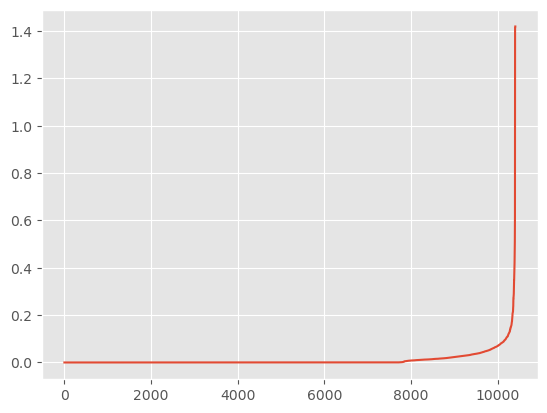

In [43]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

## KMEANS CLUSTERING

In [44]:
from sklearn.cluster import KMeans
clusterer_KMeans=KMeans(n_clusters=7).fit(model_df_final_kMEANS)
clusterer_KMeans

KMeans(n_clusters=7)

In [52]:
pred_KMeans=clusterer_KMeans.predict(model_df_final_kMEANS)
pred_KMeans

array([1, 3, 1, ..., 0, 0, 0])

In [53]:
from sklearn.metrics import silhouette_score
kmeans_score = silhouette_score(model_df_final_kMEANS, pred_KMeans)
print(kmeans_score)

0.9264536398496745


## GAUSSIAN MIXTURE

In [166]:
from sklearn.mixture import GaussianMixture
clusterer_GMM = GaussianMixture(n_components=7).fit(model_df_final_kMEANS)
preds_GMM = clusterer_GMM.predict(model_df_final_kMEANS)
GMM_score = silhouette_score(model_df_final_kMEANS, preds_GMM)
print(GMM_score)

0.6521631928607328


## DBSCAN
DBSCAN is a clustering algorithm that defines clusters as continuous regions of high density and works well if all the clusters are dense enough and well separated by low-density regions.

In [48]:
model_df_final_DBSCAN[np.isnan(model_df_final_DBSCAN)] = 0 

In [49]:
DBSCAN_model = DBSCAN(eps=0.2, min_samples=4, algorithm='kd_tree')
DBSCAN_model.fit(model_df_final_DBSCAN)

DBSCAN(algorithm='kd_tree', eps=0.2, min_samples=4)

In [50]:
model_df_final_DBSCAN

array([[0.        , 0.        , 1.        , ..., 0.0851236 , 0.3519091 ,
        0.51142202],
       [0.        , 1.        , 0.        , ..., 0.41170637, 0.44354583,
        0.82359912],
       [0.        , 0.        , 1.        , ..., 0.24520154, 0.52233977,
        0.61223604],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [51]:
#looks like unsupervised ML decides there are 21 genres
clusters = DBSCAN_model.labels_
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int64)

In [52]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 
          'olive', 'goldenrod', 'lightcyan', 'navy', 'red', 'orange', 'violet',
           'green', 'yellow', 'cyan', 'magenta', 'black', 'white', 'blue', 'steelblue']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

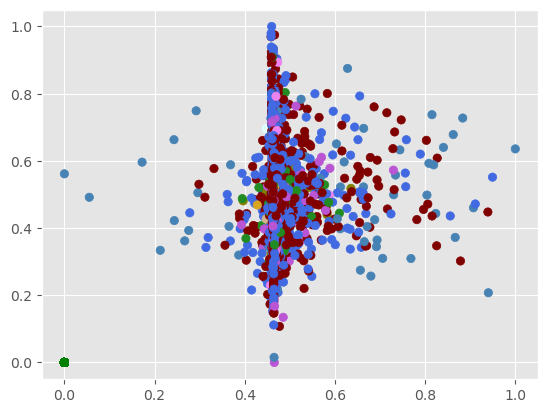

In [53]:
plt.scatter(model_df_final_DBSCAN[:,-1], model_df_final_DBSCAN[:,-2], c=vectorizer(clusters))

## t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

In [173]:
model_df_final_TSNE[np.isnan(model_df_final_TSNE)] = 0 

In [174]:
TSNE_model = TSNE(n_components=2, learning_rate=150.0, n_iter = 690, verbose=1)
X_embedded = TSNE_model.fit_transform(model_df_final_TSNE)

C:\Users\nidhi\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10405 samples in 0.002s...
[t-SNE] Computed neighbors for 10405 samples in 3.638s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10405
[t-SNE] Computed conditional probabilities for sample 2000 / 10405
[t-SNE] Computed conditional probabilities for sample 3000 / 10405
[t-SNE] Computed conditional probabilities for sample 4000 / 10405
[t-SNE] Computed conditional probabilities for sample 5000 / 10405
[t-SNE] Computed conditional probabilities for sample 6000 / 10405
[t-SNE] Computed conditional probabilities for sample 7000 / 10405
[t-SNE] Computed conditional probabilities for sample 8000 / 10405
[t-SNE] Computed conditional probabilities for sample 9000 / 10405
[t-SNE] Computed conditional probabilities for sample 10000 / 10405
[t-SNE] Computed conditional probabilities for sample 10405 / 10405
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.850441
[t-SNE] KL 

## Testing the Recommendation Model

In [175]:
df4.head(40)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,PC1,PC2,PC3,idx,rating_between,weighted_score
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,-0.059085,-0.828554,0.059845,3,between 4 and 5,4.024275
9,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,1.358246,-0.311963,0.658274,0,between 3 and 4,3.947711
10,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,0.635635,0.132229,0.253101,1,between 4 and 5,4.309809
13,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,1.127437,0.133040,0.351088,1,between 4 and 5,4.329819
14,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,0.477000,0.036854,0.349268,1,between 4 and 5,3.983410
18,18,The Ultimate Hitchhiker's Guide (Hitchhiker's ...,Douglas Adams,4.38,0517149257,9780517149256,eng,815,2877,195,1/17/1996,Wings Books,-0.162364,-1.638999,-0.032279,3,between 4 and 5,3.982697
21,21,A Short History of Nearly Everything,Bill Bryson,4.21,076790818X,9780767908184,eng,544,248558,9396,9/14/2004,Broadway Books,-0.168925,0.141238,0.041463,1,between 4 and 5,4.179450
22,22,Bill Bryson's African Diary,Bill Bryson,3.44,0767915062,9780767915069,eng,55,7270,499,12/3/2002,Broadway Books,-0.195168,-1.152766,-0.032829,3,between 3 and 4,3.855657
23,23,Bryson's Dictionary of Troublesome Words: A Wr...,Bill Bryson,3.87,0767910435,9780767910439,eng,256,2088,131,9/14/2004,Broadway Books,-0.340283,1.365683,-0.034995,4,between 3 and 4,3.943171
24,24,In a Sunburned Country,Bill Bryson,4.07,0767903862,9780767903868,eng,335,72451,4245,5/15/2001,Broadway Books,-0.290249,0.478432,-0.036582,1,between 4 and 5,4.031941


In [176]:
#use whatever model u want in place of df4:
#model_df_final_kNN 
#model_df_final_DBSCAN 
#model_df_final_TSNE 

all_books_names = list(df4.title.values)

In [177]:
def get_index_from_name(name):
    print("Your book recs for ", name)
    return df4[df4["title"]==name].index.tolist()[0]


def get_id_from_partial_name(partial):
    potential_books = dict()
    for name in all_books_names:
        if partial in name:
            potential_books[name] = all_books_names.index(name)
    
    print('u might have meant: [')
    for key in potential_books:
        print(key, potential_books[key], ',')
    print('] \n just for fun, lets use ', key, '\n' )
    
    return(potential_books[key])
            
def book_rec(query=None,indx=None):
    if indx:
        for index in indices[indx][1:]:
            print(df4.iloc[index]["title"])
    if query:
        try:
            found_id = get_index_from_name(query)
            for index in indices[found_id][1:]:
                print(df4.iloc[index]["title"])
        except:
            print("couldnt find. pls try another book")
            found_id = get_id_from_partial_name(query)
            for index in indices[found_id][1:]:
                print(df4.iloc[index]["title"])

## Testing the model on topic : "Poor People"

In [54]:
book_rec("Where the Red Fern Grows with Connections")

Your book recs for  Where the Red Fern Grows with Connections
couldnt find. pls try another book
u might have meant: [
Where the Red Fern Grows with Connections 2559 ,
] 
 just for fun, lets use  Where the Red Fern Grows with Connections 

The Best of America's Test Kitchen 2007: The Year's Best Recipes  Equipment Reviews  and Tastings
Grief Lessons: Four Plays by Euripides
Cat's Cradle/God Bless You Mr. Rosewater/Breakfast of Champions
Essays
Julius Knipl  Real Estate Photographer: The Beauty Supply District
A Guided Tour of 5 Works by Plato: Euthyphro/Apology/Crito/Phaedo/Cave


In [55]:
book_rec("Harry Potter")

Your book recs for  Harry Potter
couldnt find. pls try another book
u might have meant: [
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 0 ,
Unauthorized Harry Potter Book Seven News: "Half-Blood Prince" Analysis and Speculation 1 ,
Harry Potter Collection (Harry Potter  #1-6) 2 ,
Harry Potter Schoolbooks Box Set: Two Classic Books from the Library of Hogwarts School of Witchcraft and Wizardry 564 ,
J.K. Rowling's Harry Potter Novels: A Reader's Guide 565 ,
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 566 ,
Harry Potter Y La Piedra Filosofal (Harry Potter  #1) 904 ,
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 1126 ,
] 
 just for fun, lets use  Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 

100 Years of Lynchings
The Life and Times of Scrooge McDuck Companion
The Music of the Republic: Essays on Socrates' Conversations and Plato's Writings
Come Away My Beloved
The Lord of the Rings (The Lord of the Rings  #1-3)
The Lady in the Lake

In [56]:
book_rec("In a Sunburned Country")

Your book recs for  In a Sunburned Country
Matthew Flinders' Cat
Spring's Awakening
A Tale of Two Cities
The Cod's Tale
On Justice  Power and Human Nature: Selections from The History of the Peloponnesian War
The Moor's Last Sigh


In [58]:
book_rec("The Lord of the Rings: Complete Visual Companion")

Your book recs for  The Lord of the Rings: Complete Visual Companion
The Last Hours of Ancient Sunlight: The Fate of the World and What We Can Do Before It's Too Late
Divine Conspiracy: Rediscovering Our Hidden Life in God
With Open Hands
Betsy Was a Junior (Betsy-Tacy  #7)
The Sun in the Morning: My Early Years in India and England
  said the shotgun to the head.


In [178]:
book_rec("Annals of the Former World")

Your book recs for  Annals of the Former World
Answered Prayers
Posing for Portrait Photography: A Head-To-Toe Guide
The Pizza Monster (Olivia Sharp  Agent for Secrets #1)
Waverley
The Evidence-Based Social Work Skills Book
Any Woman's Blues
